# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score 
import warnings

In [2]:
def line():
    print('----------------------------------------------')

In [3]:
data = pd.read_csv('/datasets/Churn.csv')
mass_name = []
for element in data.columns:
    mass_name.append(element[0].lower() + element[1:])
    
data.columns = mass_name

data[data.duplicated()]
line()
print(data.isnull().sum())
line()

# Конечно тут необходимо уточнение у того кто нам эти данные дал, но по логике нет недвижимости, значит (NaN или 0), и не тут
# то было у нас также есть и те у кого недвижимость == 0. Прочитал, что в категориальных переменных лучше заменять такие значения на 
# наиболее часто встречаемое, если это не так, поправь.

print(data['tenure'].value_counts())
line()
data['tenure'] = data['tenure'].fillna(1.0).astype('int')
print(data.info())
line()
display(data)

----------------------------------------------
rowNumber            0
customerId           0
surname              0
creditScore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numOfProducts        0
hasCrCard            0
isActiveMember       0
estimatedSalary      0
exited               0
dtype: int64
----------------------------------------------
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rowNumber          10000 non-null int64
customerId         10000 non-null int64
surname            10000 non-null object
creditScore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age           

,rowNumber,customerId,surname,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Комментарий: На этапе предобработки мы изменили регистр первого символа в названии столбцов для удобства, проверили на дубликаты данные, их также не обнаружено, нашли пропуски (количество недвижимости) которые нельзя удалять т.к они составляют 10% от всех данных, поэтому было принято решение заменить их на наиболее часто встречаемое (прочитал в статье https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce). Данные пропуски по всей видимости получены совершенно случайно т.к если бы мы хотели указать то, что недвижимость у этих клиентов отсутствует, мы бы увидели вместо пропусков значение "0".

In [4]:
# Выполним прямое кодирование

data_ohe = pd.get_dummies(data, drop_first = True)

# Выполним разделение выборки на обучающу валидационную и тестовую

features = data_ohe.drop(['exited'], axis = 1)
target = data_ohe['exited']

# Получение пропорции 60:40

features_train, features_40, target_train, target_40 = train_test_split(
    features, target, test_size = 0.40, random_state = 12345)

# Разделение 40 % на две части

features_valid, features_test, target_valid, target_test = train_test_split(
    features_40, target_40, test_size = 0.50, random_state = 12345)

In [5]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Масштабирование признаков

numeric = ['rowNumber', 'customerId', 'creditScore', 'age','tenure', 'balance', 'numOfProducts', 'estimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Комментарий: Для дальнейшей работы с данными, мы разделили их в пропорции 60:40:40 (train/valid/test), а также отмасштабировали их при помощи класса StandardScaler.

# 2. Исследование задачи

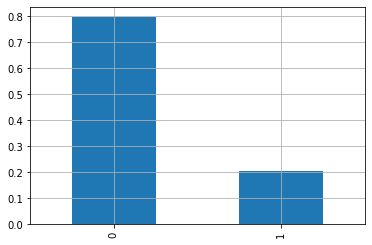

Нулевой класс превышает первый на 59.26%


In [6]:
class_exited = target.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.show()

print('Нулевой класс превышает первый на {:.2%}'.format(class_exited[0] - class_exited[1]))

In [7]:
# Выберем 3 модели которые будем обучать и выберем лучшую из них для доработки гиперпараметров

warnings.filterwarnings("ignore", category=FutureWarning)

mass_model = {'Логистическая регрессия' : LogisticRegression(solver = 'liblinear', random_state = 12345), 
              'Рандомный лес': RandomForestClassifier(random_state = 12345), 
              'Решающее дерево': DecisionTreeClassifier(random_state = 12345)}

for name, model in mass_model.items():
    model = model
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    print(name, 'F1:', f1_score(target_valid, predict))
    
    # Добавлен рассчет AUC_ROC
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    print(name, 'AUC_ROC:', auc_roc)

Логистическая регрессия F1: 0.348111658456486
Логистическая регрессия AUC_ROC: 0.7424116405252875
Рандомный лес F1: 0.43936731107205623
Рандомный лес AUC_ROC: 0.7852598612379702
Решающее дерево F1: 0.5419354838709678
Решающее дерево AUC_ROC: 0.7047359952576534


Комментарий: Исходя из исследования мы обнаружили нарушение баланса классов, который необходимо будет в дальнейшем устранить. В нашей задаче меток с классом 0 > чем меток с классом 1. Также мы выяснили, что без учета баланса классов лучше всего в предсказании себя проявляет решающее дерево, именно его гиперпараметры мы и будем настраивать для достижения желаемого результата (f1 > 0.59)

# 3. Борьба с дисбалансом

# Построение моделей при помощи (upsampling)

In [8]:
# Cбалансируем классы. Увеличим в 4 раза размерность 1 класса

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

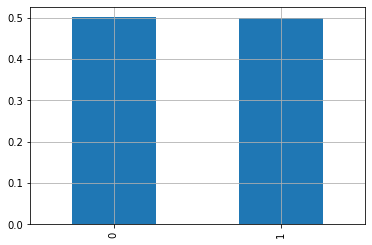

In [9]:
# Проверим, правльно ли мы сбалансировали классы

class_exited = target_train_upsampled.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.show()

In [10]:
for name, model in mass_model.items():
    model = model
    model.fit(features_train_upsampled, target_train_upsampled)
    predict = model.predict(features_valid)
    print(name, 'F1:', f1_score(target_valid, predict))

Логистическая регрессия F1: 0.46828358208955223
Рандомный лес F1: 0.4938650306748466
Решающее дерево F1: 0.5433255269320842


Комментарий: Без настройки гиперпараметров, себя также лучше всего показывает на сбалансированных классах модель решающего дерева

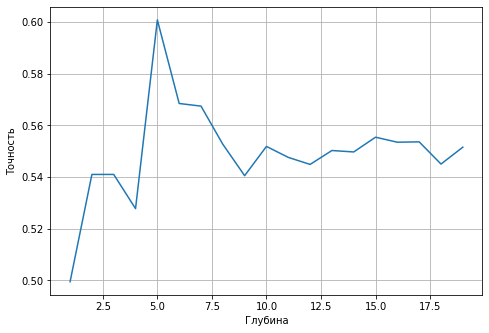

Лучшая точность: 0.6008403361344538 c значением глубины = 5
Значение AUC_ROC: 0.8343868520859672


In [11]:
# Решающее дерево

best_result = 0
depth = 0
model_up = None
accuracy_arr_tree = []

for i in range(1, 20):    
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model.fit(features_train_upsampled, target_train_upsampled)
    predict = model.predict(features_valid)
    score = f1_score(target_valid, predict)
    accuracy_arr_tree.append(score)
    if score > best_result:
        best_result = score
        depth = i
        model_up = model
accuracy_arr_tree = pd.Series(accuracy_arr_tree) 

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.grid()
ax.set_xlabel('Глубина')
ax.set_ylabel('Точность')
    
ax.plot(accuracy_arr_tree.index + 1, accuracy_arr_tree)
plt.show()

print("Лучшая точность:", best_result, 'c значением глубины =', depth)

probabilities_valid = model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)

Комментарий: При настройке гиперпараметров мы добились максимального показателя метрики F1 = 0.6 при глубине = 5, посмотрим далее, что произойдет при обучении данной модели на тестовой выборке. Также по значению AUC_ROC, при данных настройках гиперпараметров мы можем сказать, что от случайной модели мы оторвались на 0.33

# Построение моделей при помощи (downsampling)

In [12]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

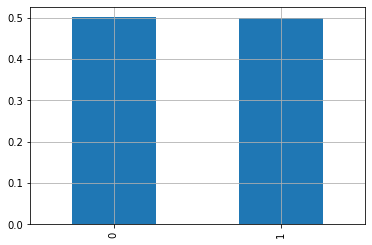

In [13]:
# Проверим, правльно ли мы сбалансировали классы

class_exited = target_train_downsampled.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.show()

In [14]:
for name, model in mass_model.items():
    model = model
    model.fit(features_train_downsampled, target_train_downsampled)
    predict = model.predict(features_valid)
    print(name, 'F1:', f1_score(target_valid, predict))

Логистическая регрессия F1: 0.4848484848484848
Рандомный лес F1: 0.5245245245245246
Решающее дерево F1: 0.5017543859649123


Комментарий: Интересно, рандомный лес показывает лучше значение метрики F1 чем решающее дерево. Попробуем покрутить гиперпараметры обоих в моделях

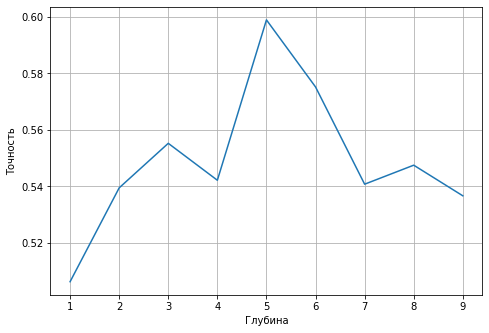

Лучшая точность: 0.598984771573604 c значением глубины = 5
Значение AUC_ROC: 0.8308784834169092


In [15]:
# Решающее дерево

best_result = 0
depth = 0
model_down = None
accuracy_arr_tree = []

for i in range(1, 10):    
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model.fit(features_train_downsampled, target_train_downsampled)
    predict = model.predict(features_valid)
    score = f1_score(target_valid, predict)
    accuracy_arr_tree.append(score)
    if score > best_result:
        best_result = score
        depth = i
        model_down = model

accuracy_arr_tree = pd.Series(accuracy_arr_tree) 

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.grid()
ax.set_xlabel('Глубина')
ax.set_ylabel('Точность')
    
ax.plot(accuracy_arr_tree.index + 1, accuracy_arr_tree)
plt.show()

print("Лучшая точность:", best_result, 'c значением глубины =', depth)

probabilities_valid = model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)

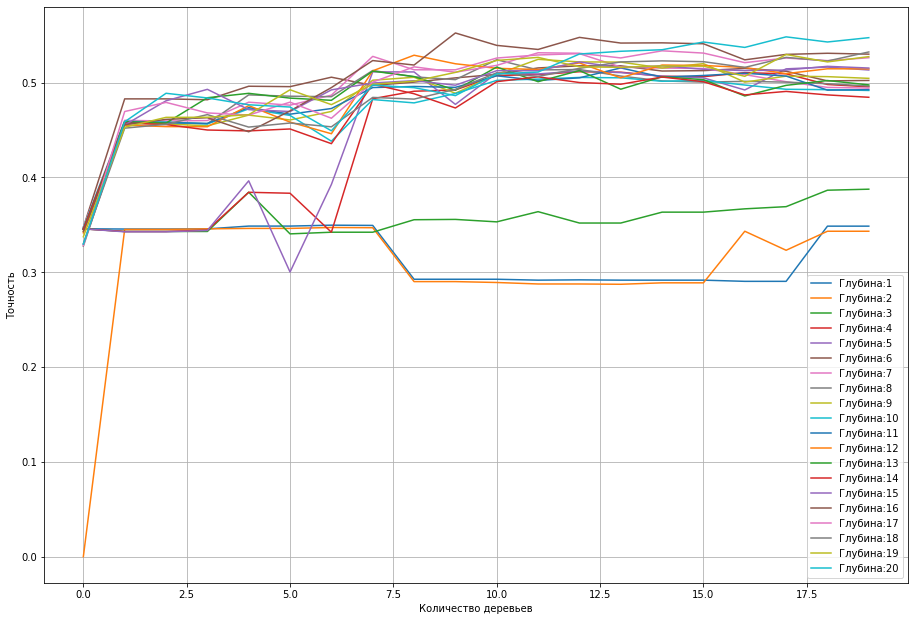

Лучшая точность:  0.5522531160115054 при глубине = 16 и количестве деревьев = 10
Значение AUC_ROC: 0.795180832209244


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.345740,0.000000,0.345705,0.345705,0.345705,0.347178,0.347639,0.327434,0.343220,0.346723,0.344974,0.341463,0.345339,0.345339,0.329282,0.342733,0.328194,0.330011,0.337349,0.329670
1,0.345485,0.345114,0.342918,0.342918,0.342553,0.482759,0.460137,0.458109,0.457014,0.458992,0.458176,0.455026,0.458743,0.457229,0.455194,0.455521,0.469438,0.451876,0.452859,0.458589
2,0.345485,0.345114,0.342918,0.342918,0.342553,0.482759,0.459439,0.457406,0.456325,0.458302,0.457831,0.453515,0.457229,0.455715,0.480734,0.461131,0.479053,0.455959,0.463267,0.488656
3,0.345628,0.345689,0.342918,0.344315,0.343949,0.481842,0.459909,0.456572,0.454340,0.456325,0.456884,0.453374,0.483955,0.449923,0.492813,0.462874,0.467938,0.466151,0.463366,0.483729
4,0.348597,0.346154,0.384333,0.384236,0.396330,0.496084,0.479255,0.486972,0.465625,0.472200,0.473552,0.475610,0.488605,0.448980,0.471429,0.448052,0.465707,0.453008,0.466059,0.476541
5,0.348597,0.346154,0.340381,0.383241,0.300144,0.495652,0.476112,0.485569,0.460515,0.465306,0.466607,0.458265,0.483556,0.451017,0.469424,0.470054,0.479295,0.457291,0.492366,0.474153
6,0.349558,0.347120,0.342133,0.342133,0.392494,0.505618,0.486667,0.485062,0.469492,0.438144,0.472597,0.446005,0.481255,0.435525,0.492252,0.494662,0.462338,0.453287,0.476675,0.449086
7,0.349300,0.346863,0.342133,0.482931,0.511251,0.496970,0.527583,0.512681,0.502434,0.482068,0.494700,0.512351,0.512031,0.498120,0.499510,0.523166,0.500463,0.484305,0.498127,0.497297
8,0.292524,0.290043,0.355301,0.490809,0.511171,0.500433,0.513438,0.506003,0.505535,0.478528,0.495853,0.528801,0.506305,0.488174,0.501923,0.518448,0.516544,0.482511,0.501398,0.494604
9,0.292524,0.290043,0.355641,0.492218,0.476954,0.504889,0.513417,0.503046,0.488696,0.488414,0.494922,0.519774,0.491958,0.473157,0.497186,0.552253,0.510870,0.492780,0.510678,0.486188


In [16]:
# Случайный лес (голосование)

best_model_rand_forest = None
rand_forest_res = {}
best_result = 0
best_est = 0
best_depth = 0

for depth in range(1,21):
    accuracy_arr_rand_forest = []
    for est in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train_downsampled, target_train_downsampled)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction)
        accuracy_arr_rand_forest.append(result)
        
        if best_result < result:
            best_result = result
            best_est = est
            best_depth = depth
            best_model_rand_forest = model
        
    rand_forest_res.update({depth : accuracy_arr_rand_forest})

data_rand_forest = pd.DataFrame(rand_forest_res)

fig = plt.figure()

ax = fig.add_axes([0,0,2,2])

ax.grid()
ax.set_xlabel('Количество деревьев') 
ax.set_ylabel('Точность')

for name_column in range(len(data_rand_forest)):
    ax.plot(data_rand_forest.index, data_rand_forest[name_column + 1], label = 'Глубина:' + str(name_column + 1))
    
ax.legend()
plt.show()

print('Лучшая точность: ', data_rand_forest.max().max(), 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est))

# Добавлено значение AUC_ROC
probabilities_valid = best_model_rand_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)
#---------------------------------------------------------------

display(data_rand_forest)

Комментарий: Все стало понятно. Случайный лес в 1000 раз медленнее и + не доходит до точности, решающего дерева, однозначно используем решающее дерево для работы с тестовой выборкой

# 4. Тестирование модели

In [17]:
# upsampling

predict = model_up.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))

# Добавлено значение AUC_ROC
probabilities_valid = model_up.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)
#------------------------------------------------------------

Значение F1 меры: 0.5843621399176954
Значение AUC_ROC: 0.8348916382214189


In [18]:
# downsamling

predict = model_down.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))

# Добавлено значение AUC_ROC
probabilities_valid = model_down.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)
#------------------------------------------------------------

Значение F1 меры: 0.6077003121748179
Значение AUC_ROC: 0.8356981490725874


# Вывод

В данном проекте проделаны и выполнены следующие шаги:
    
1. Первичная предобработка данных;
2. Прямое кодирование категориальных переменных;
3. Произведено масштабирование;
4. Проведена проверка на баланс классов;
5. Сбалансированы классы;
6. Опробованы несколько моделей для решения поставленной задачи;
7. Найдены критери при которых мы получаем F1 меру > 0.59;
8. Совместно с F1 мерой была найдена метрика AUC_ROC, которая дала нам понять на сколько мы улучшили модель относительно случайной.

Как показало данное исследование лучшей моделью для решения поставленной задачи оказалась модель решающего дерева, также мы выяснили что для этой задачи больше походит настройка баланса downsampling, можно предположить, что так получается исходя из того, что мы можем более тонко настроить соотношение наших классов, а это не мало важно. Основная цель достигнута F1 > 0.59

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*